# 3. Gates

This course is derived from the course Biological Circuit Design by Michael Elowitz and Justin Bois, 2020 at Caltech. The original course material has been changed by Matthias Fuegger and Thomas Nowak.

<hr>

Let's load some libraries we will need.

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

# Feed forward loop (FFL)

A motive commonly found in cells like _E. coli_ is the so called feed forward loop (FFL).
The name is unfortunately misleading since it has convergent paths, but not a loop - we will
nonetheless use it since it is established in literature.

The motive comprises of 3 species, let's call them $X,Y,Z$, and three interactions among them
along two paths:

\begin{align}
&X \rightarrow Y \rightarrow Z\\
&X \quad \rightarrow \quad Z
\end{align}

We think of $X$ as a circuit input and $Z$ as its output. 
Interactions can be activating and repressing, which we will denote by
$X \to Y$ for an _activating_ interaction and $X -\mid Y$ for a _repressing_ interaction
of $X$ on $Y$.

We say a path is *activating* if the number of repressing interacting along it is even.
It is *repressing* otherwise.

Following literature, we call a FFl *coherent* if both paths are either activating or repressing and
*incoherent* if one is repressing and the other activating.


## FFL types

There are a total of $2^3 = 8$ different FFLs depending on which of the interactions are activating and repressing. All are shown below, in a figure taken from [Alon, *Nature Rev. Genet.*, 2007](https://doi.org/10.1038/nrg2102). 

<div style="width: 400px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/FFL_classes.png" alt="FFL classes">
</figure>
    
</div>

The figure also indicates common abbreviations for these circuits: e.g., C2-FFL is the coherent FFL of type 2 and I4-FFL is the incoherent FFL of type 4.

## The most-encountered FFLs

While FFLs in general are motifs, some FFLS are more often encountered than others. In the figure below, also taken from [the Alon review](https://doi.org/10.1038/nrg2102), we see relative abundance of the eight different FFLs in *E. coli* and *S. cerevisiae*. Two FFLs, C1-FFL and I1-FFL stand out as having much higher abundance than the other six. 

<div style="width: 250px; margin: auto; margin-top: 20px">

![FFL abundance](figs/i1-ffl.png)

</div>

We will take a look at these two FFLs in turn to see what features they might provide. First, though, we need to consider the **logic of regulation** by more than one transcription factor.

## Logic of regulation by two transcription factors

Because X and Y both regulate Z in an FFL, we need to specify how they do that. 
For the sake of illustration, let us assume we are discussing C1-FFL, where

$$
Y \rightarrow Z\\
X \rightarrow Z
$$

We distinguish between two semantics:
* One can imagine a scenario where both X and Y need to be present to turn on Z. For example, they could be binding partners that together serve to recruit polymerase to the promoter.
  To get expression of Z, we must have `X AND Y`.

* Conversely, if either X or Y may each alone activate Z, we have that Z is expressed if `X OR Y`.

So, to fully specify an FFL, we need to also specify the logic of how Z is regulated. So, we might have, for example, a C1-FFL with OR logic. This gives a total of $2 \cdot 8 = 16$ possible FFLs.

We are now left with the task of mathematically modeling `AND` and `OR` logic.

### Logic with two activators

Assume that $z = f_{AND}(x,y)$ is the normalized (within $[0,1]$) steady state input-output behavior of `Z = X AND Y`.
Likewise, $z = f_{OR}(x,y)$ is the normalized steady state input-output behavior of `Z = X OR Y`.


Let $f$ be either $f_{AND}$ or $f_{OR}$.
The dynamics of the concentration of $Z$ may then be written as

\begin{align}
\frac{\mathrm{d}z}{\mathrm{d}t} = \beta_0\,f(x, y) - \gamma z\enspace,
\end{align}

where $\beta_0$ is the maximal production rate and
$\gamma$ is its degradation/dilution rate.

Our goal is to specify the dimensionless function $f(x, y)$ that encodes the appropriate logical functions.
There are two ways we can come up with a candidate function:
* We could derive the functional form from the molecular details of the promoter region and the activators. 
  We will however, not follow this modeling path for the moment.

* We can use a phenomenological, generalized Hill function and parametrize it to experimental data.

Remember from Lecture 1 (chapter Activation) that for an activator $X$, the approximate production rate of the regulated $Z = f(X)$
was
\begin{align}
  \beta(X) = \beta_0 \frac{X/K_\mathrm{d}}{1+X/K_\mathrm{d}} \enspace,
\end{align}
where $\beta_0$ is the maximal production rate and $K_d$ the dissociation constant $k_-/k_+$.
Generalizing this to higher order Hill coefficients $n \geq 1$ we can write
\begin{align}
  \beta(X) = \beta_0 \frac{(X/K_\mathrm{d})^n}{1+(X/K_\mathrm{d})^n} \enspace,
\end{align}
The result is a sharper, say "more digital", dependency of the production rate with respect to
the activator $X$.

A natural generalization to two inputs is to form the AND by multiplying and the OR by adding
$(X/K_\mathrm{d})^n$ terms as follows:

\begin{align}
f_{AND}(x,y) &= \frac{(x/k_x)^{n_x} (y/k_y)^{n_y}}{1 + (x/k_x)^{n_x} (y/k_y)^{n_y}}\\[1em]
f_{OR}(x,y) &= \frac{(x/k_x)^{n_x} + (y/k_y)^{n_y}}{1 + (x/k_x)^{n_x} + (y/k_y)^{n_y}} \enspace.
\end{align}

In what follows, we will substitute $x/k_x \to x$ and $y/k_y \to y$ such that $x$ and $y$ are now dimensionless, nondimensionalized by their Hill $k$. In this notation, we have

\begin{align}
f_{AND}(x,y) &= \frac{x^{n_x} y^{n_y}}{1 + x^{n_x} y^{n_y}}\\[1em]
f_{OR}(x,y)  &= \frac{x^{n_x} + y^{n_y}}{1 + x^{n_x} + y^{n_y}} \enspace.
\end{align}

We can make plots of these functions to demonstrate how they represent the respective logic.

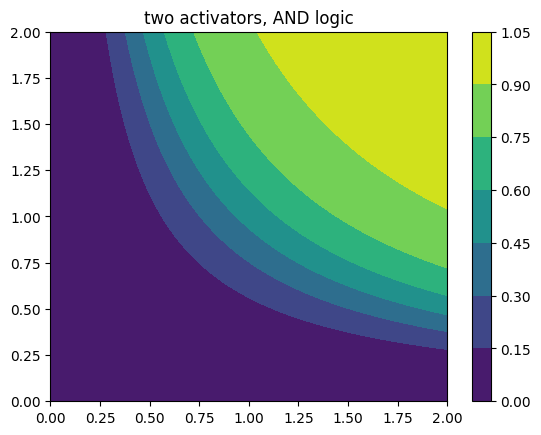

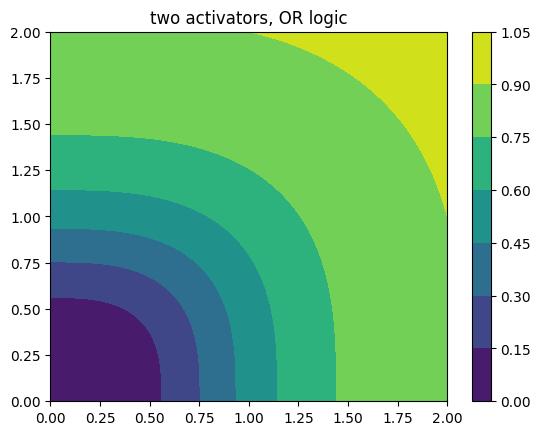

In [3]:
def contour_fun(x, y, z, title=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    cbar = plt.colorbar(CS)
    if title is not None:
        plt.title(title)


# Get x and y values for plotting
x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
xx, yy = np.meshgrid(x, y)

# Parameters (Hill functions)
# increase them to make it more digital
nx = 3  # 20
ny = 3  # 20

# Regulation functions
def aa_and(x, y, nx, ny):
    comb = x ** nx * y ** ny
    return  comb / (1 + comb)


def aa_or(x, y, nx, ny):
    comb = x ** nx + y ** ny
    return comb / (1 + comb)

# plot it
contour_fun(xx, yy,
            aa_and(xx, yy, nx, ny),
            title="two activators, AND logic")

contour_fun(xx, yy,
            aa_or(xx, yy, nx, ny),
            title="two activators, OR logic")

Here, purple indicates that $f(x, y) = 0$ (low) and yellow indicates that $f(x, y) = 1$ (high).

## Logic with two repressors

Now let's consider the case where we have two repressors, as in the C3-FFL or I2-FFL.
The `AND` case where X and Y are both repressors is `(NOT X) AND (NOT Y) = NOR(X,Y)`.
Here, either repressor (or both) can shut down gene expression.
Logic gates that work in this way are used in synthetic designs for their ease of design and possibilities to
vary input and output species.
We come to this later.

For the `OR` of two repressors, we have `(NOT X) OR (NOT Y) = NAND(X,Y)`.
We might get this kind of logic if the two repressors need to work in concert, perhaps through binding interactions, to affect repression.

We can encode these two input-output functions with dimensionless Hill regulation functions

\begin{align}
f_{NOR}(x,y)  &= \frac{1}{(1 + x^{n_x}) (1 + y^{n_y})}\\[1em]
f_{NAND}(x,y) &= \frac{1 + x^{n_x} + y^{n_y}}{(1 + x^{n_x}) ( 1 + y^{n_y})}\enspace.
\end{align}


### The NOR gate
Since the `NOR` gate is of great practical relevance we will also provide a derivation for its
steady state input-output approximation.

Assume that two repressors $X$ and $Y$ bind respective binding sites $P_X$ and $P_Y$ of a promoter $P$.
Only if neither is present, a protein will be produced.
We have,
\begin{align}
f_{NOR}(x,y) = \frac{P}{P^{tot}}\enspace, 
\end{align}
where $P^{tot} = P + P^{occ}$ is the total number of promoters with $P^{occ}$ being the number of promoters occupied by either $X$ or $Y$.
In particular, since $X$ and $Y$ are independent, the fraction of promoters that are free is the product of the fractions of promoters that have free $X$-binding-sites and those that have free $Y$-binding-sites.
Thus, with
\begin{align}
K^d_x &= \frac{P_x \cdot x}{P^{occ}_x}\\
K^d_y &= \frac{P_y \cdot y}{K^{occ}_y}\enspace.
\end{align}
it is
\begin{align}
\frac{P}{P^{tot}} = \frac{1}{1+\frac{x}{K^d_x}} \cdot \frac{1}{1+\frac{y}{K^d_y}} = f_{NOR}(x,y)\enspace,
\end{align}
with Hill coefficients $1$.

Let's make some plots to see how these functions look.

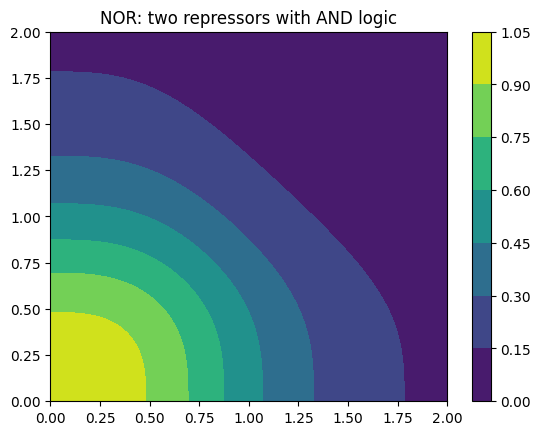

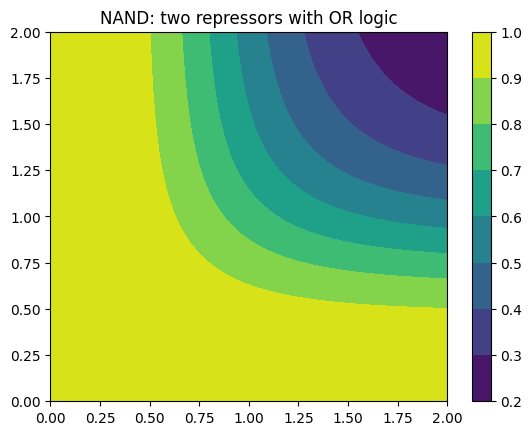

In [17]:
# Regulation functions
def rr_and(x, y, nx, ny):
    return 1 / (1 + x ** nx) / (1 + y ** ny)


def rr_or(x, y, nx, ny):
    return (1 + x ** nx + y ** ny) / (1 + x ** nx) / (1 + y ** ny)


# Parameters (Hill functions)
# increase them to make it more digital
nx = 3  # 20
ny = 3  # 20

# Generate plots
contour_fun(xx, yy,
            rr_and(xx, yy, nx, ny),
            title="NOR: two repressors with AND logic")

contour_fun(xx, yy,
            rr_or(xx, yy, nx, ny),
            title="NAND: two repressors with OR logic")

### Logic with one activator and one repressor

Now say we have one activator (which we will designate to be A) and one repressor (which we will designate to be R). Now, `AND` logic means `A AND (NOT R)`, and `OR` logic means `A OR (NOT R)`.

The dimensionless regulatory functions are

\begin{align}
f_{ANDNOT}(x,y) &= \frac{x^{n_x}}{1 + x^{n_x} + y^{n_y}}\\[1em]
f_{ORNOT}(x,y) &= \frac{1 + x^{n_x}}{1 + x^{n_x} + y^{n_y}}\enspace.
\end{align}


Finally, let's look at a plot.

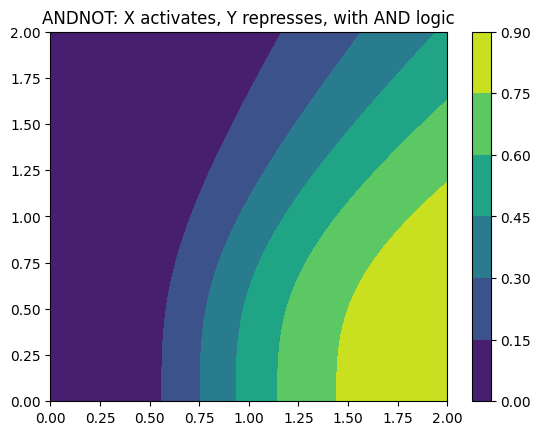

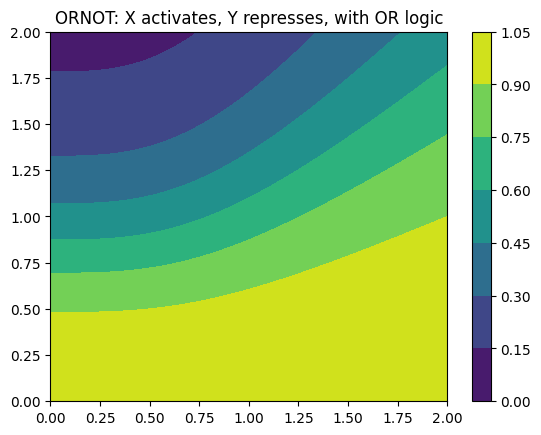

In [18]:
# Regulation functions
def ar_and(x, y, nx, ny):
    return x ** nx / (1 + x ** nx + y ** ny)


def ar_or(x, y, nx, ny):
    return (1 + x ** nx) / (1 + x ** nx + y ** ny)

# Parameters (Hill functions)
# increase them to make it more digital
nx = 3  # 20
ny = 3  # 20

# Generate plots
contour_fun(xx, yy,
            ar_and(xx, yy, nx, ny),
            title="ANDNOT: X activates, Y represses, with AND logic")

contour_fun(xx, yy,
            ar_or(xx, yy, nx, ny),
            title="ORNOT: X activates, Y represses, with OR logic")

## A word of warning

The above generalized Hill functions for two inputs have been deemed useful in phenomenologically describing
gates. They should **not** be interpreted as **the way** to model AND/OR combinations of activators/repressors.
Your concrete genetic circuit may require a different function to describe normalized steady-state input-output behavior.

## Dynamical equations for FFLs

To analyze the C1-FFL and I1-FFL (or any of the other FFLs), in response to changes in the input X, we can write a generic system of ODEs for the concentrations of Y and Z. We know that Y is either activated or repressed by X and itself experiences degradation. We define a dimensionless function $f_y(x/k_{xy}; n_{xy})$ to describe the activating or repressive Hill function for the regulation of X by Y. We have used the notation that $n_{ij}$ is the Hill coefficient for *j* regulated by *i*, with $k_{ij}$ similarly defined. To be explicit:

* If X **activates** Y, then

    \begin{align}
    f_y(x/k_{xy}; n_{xy}) = \frac{(x/k_{xy})^{n_{xy}}}{1 + (x/k_{xy})^{n_{xy}}}\enspace.
    \end{align}

* If X **represses** Y, then

    \begin{align}
    f_y(x/k_{xy}; n_{xy}) = \frac{1}{1 + (x/k_{xy})^{n_{xy}}}\enspace.
    \end{align}

The dynamical equation for $y$ for either activating or repressive action by X is

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta_y\,f_y(x/k_{xy}; n_{xy}) - \gamma_y y.
\end{align}

Similarly, we define the dimensionless function $f_z(x/k_{xz}, y/k_{yz}; n_{xz}, n_{yz})$ to describe the regulation in expression of Z by X and Y. This have any of the functional forms we have listed above for activation/repression pairs and AND/OR logic. The dynamical equation for $z$ is then

\begin{align}
\frac{\mathrm{d}z}{\mathrm{d}t} &= \beta_z\,f_z(x/k_{xz}, y/k_{yz}; n_{xz}, n_{yz}) - \gamma_z z.
\end{align}

We can nondimensionalize these equations by choosing

\begin{align}
t &= \tilde{t} / \gamma_y, \\[1em]
x &= k_{xz}\,\tilde{x},\\[1em]
y &= k_{yz}\,\tilde{y},\\[1em]
z &=z_0\,\tilde{z},
\end{align}

where $z_0$ is as of yet unspecified. Inserting these expressions into the dynamical equations gives

\begin{align}
\gamma_y k_{yz}\,\frac{\mathrm{d}\tilde{y}}{\mathrm{d}\tilde{t}} &= \beta_y\,f_y\left(\frac{k_{xz}}{k_{xy}}\,\tilde{x}; n_{xy}\right) - \gamma_y k_{yz} \tilde{y},\\[1em]
\gamma_y z_0\,\frac{\mathrm{d}\tilde{z}}{\mathrm{d}\tilde{t}} &= \beta_z\,f_z(\tilde{x}, \tilde{y}; n_{xz}, n_{yz}) - \gamma_z z_0 \tilde{z}.
\end{align}

If we conveniently define $z_0 = \beta_z/\gamma_z$, then the dynamical equations become

\begin{align}
\frac{\mathrm{d}\tilde{y}}{\mathrm{d}\tilde{t}} &= \beta\,f_y\left(\kappa\tilde{x}; n_{xy}\right) - \tilde{y},\\[1em]
\gamma^{-1}\,\frac{\mathrm{d}\tilde{z}}{\mathrm{d}\tilde{t}} &= f_z(\tilde{x}, \tilde{y}; n_{xz}, n_{yz}) - \tilde{z},
\end{align}

where we have defined

\begin{align}
&\beta = \frac{\beta_y}{\gamma_y k_{yz}},\\[1em]
&\gamma = \frac{\gamma_z}{\gamma_y}, \\[1em]
&\kappa = \frac{k_{xz}}{k_{xy}}.
\end{align}

In addition to the Hill coefficients, these dimensionless parameters complete the parameter set of the FFL dynamical system. Each has a physical meaning. The parameter $\beta$ is the dimensionless unregulated steady state level of $y$, $\gamma$ is the ratio of the decay rates of Z and Y, and $\kappa$ is the ratio of the amounts of X that are necessary to regulate Z and Y.

Henceforth, we will work with these dimensionless equation and will drop the tildes for notational convenience.

## Numerical solution of the FFL circuits

To specify the dynamical equations so that we may numerically solve them, we need to specify the functions $f_y$ and $f_z$ along with their Hill coefficients. The function $f_y$ is either an activating or repressive Hill function, and the functions $f_z$ have already been defined as `aa_and()`, `aa_or()`, etc., above. For convenience in future lessons, these functions are included in the `biocircuits.reg` submodule.

Let's proceed to code up the right-hand side of the dynamical equations for FFLs. It is convenient to define a function that will give back a function that we can use as the right-hand side we need to specify to `scipy.integrate.odeint()`. Remember that `odeint()` requires a function of the form `func(yz, t, *args)`, where `yz` is an array containing the values of $y$ and $z$. For convenience, our function will return a function with call signature `rhs(yz, t, x)`, where `x` is the value of $x$ at a given time point.

In [6]:
# Regulation functions
def a_hill(x, nx):
    comb = x ** nx
    return  comb / (1 + comb)


def r_hill(x, nx):
    comb = x ** nx
    return 1 / (1 + comb)


# get FFL functions
def ffl_rhs(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic):
    """Return a function with call signature fun(yz, x) that computes
    the right-hand side of the dynamical system for an FFL. Here,
    `yz` is a length two array containing concentrations of Y and Z.
    """
    if ffl[:2].lower() in ("c1", "c3", "i1", "i3"):
        fy = lambda x: a_hill(x, n_xy)
    else:
        fy = lambda x: r_hill(x, n_xy)

    if ffl[:2].lower() in ("c1", "i4"):
        if logic.lower() == "and":
            fz = lambda x, y: aa_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: aa_or(x, y, n_xz, n_yz)
    elif ffl[:2].lower() in ("c4", "i1"):
        if logic.lower() == "and":
            fz = lambda x, y: ar_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: ar_or(x, y, n_xz, n_yz)
    elif ffl[:2].lower() in ("c2", "i3"):
        if logic.lower() == "and":
            fz = lambda x, y: ar_and(y, x, n_yz, n_xz)
        else:
            fz = lambda x, y: ar_or(y, x, n_yz, n_xz)
    else:
        if logic.lower() == "and":
            fz = lambda x, y: rr_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: reg.rr_or(x, y, n_xz, n_yz)

    def rhs(yz, t, x):
        y, z = yz
        dy_dt = beta * fy(kappa * x) - y
        dz_dt = gamma * (fz(x, y) - z)

        return np.array([dy_dt, dz_dt])

    return rhs

To study the dynamics, we will investigate how the circuit responds to a step up in concentration of X, assuming all concentrations are initially zero, and how a circuit at steady state with nonzero concentration of X responds to a step down in X to zero. This case is particularly relevant for a C1-FFL and an I1-FFL, since in the absence of X (and leakage), the steady state levels of both Y and Z are zero. For other FFLs, the steady state concentrations of Y or Z absent X can be nonzero. In this case, you can think of the sudden rise in X being associated also with a sudden rise of effectors that allow Y and Z to turn on.

Now we can write a function to solve the ODEs. Because the steps are discontinuous, we need to solve the ODEs in a piecewise manner. We specify that the step up starts at $t = 0$, and we will allow the time of the step down to be specified. The magnitude of the step up, $x_0$ will also be specified.

In [7]:
def solve_ffl(
    beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic, t, t_step_down, x_0
):
    """Solve an FFL. The dynamics are given by
    `rhs`, the output of `ffl_rhs()`.
    """
    if t[0] != 0:
        raise RuntimeError("time must start at zero.")

    rhs = ffl_rhs(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic)

    # Integrate if we do not step down
    if t[-1] < t_step_down:
        return scipy.integrate.odeint(rhs, np.zeros(2), t, args=(x_0,))

    # Integrate up to step down
    t_during_step = np.concatenate((t[t < t_step_down], (t_step_down,)))
    yz_during_step = scipy.integrate.odeint(
        rhs, np.zeros(2), t_during_step, args=(x_0,)
    )

    # Integrate after step
    t_after_step = np.concatenate(((t_step_down,), t[t > t_step_down]))
    yz_after_step = scipy.integrate.odeint(
        rhs, yz_during_step[-1, :], t_after_step, args=(0,)
    )

    # Concatenate solutions
    if t_step_down in t:
        return np.vstack((yz_during_step[:-1, :], yz_after_step))
    else:
        return np.vstack((yz_during_step[:-1, :], yz_after_step[1:, :]))

Finally, we can write a function to solve and plot the dynamics of an FFL for a unit step.  
At the end of this notebook, we have a dashboard to explore the C1-FFL and I1-FFL, but for the pedagogical purposes of exposing design principles here, we will vary the parameters one-by-one as we work down the notebook.

In [8]:
colors = ['red', 'green', 'blue']

def plot_ffl(
    beta=1,
    gamma=1,
    kappa=1,
    n_xy=1,
    n_xz=1,
    n_yz=1,
    ffl="c1",
    logic="and",
    t=np.linspace(0, 20, 200),
    t_step_down=10,
    x_0=1,
    normalized=False,
):
    yz = solve_ffl(
        beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic, t, t_step_down, x_0
    )
    y, z = yz.transpose()

    # Generate x-values
    if t[-1] > t_step_down:
        t_x = np.array(
            [-t_step_down / 10, 0, 0, t_step_down, t_step_down, t[-1]]
        )
        x = np.array([0, 0, x_0, x_0, 0, 0])
    else:
        t_x = np.array([-t[-1] / 10, 0, 0, t[-1]])
        x = np.array([0, 0, x_0, x_0])

    # Add left part of y and z-values
    t = np.concatenate(((t_x[0],), t))
    y = np.concatenate(((0,), y))
    z = np.concatenate(((0,), z))

    # Set up figure
    plt.figure()
    plt.xlabel("dimensionless time")
    plt.ylabel(f"{'norm. ' if normalized else ''}dimensionless conc.")

    if normalized:
        x = x / x.max()
        y = y / y.max()
        z = z / z.max()
    
    plt.plot(t_x, x, color=colors[0], label="x")
    plt.plot(t, y, color=colors[1], label="y")
    plt.plot(t, z, color=colors[2], label="z")

    plt.legend()

## The C1-FFL circuit enables sign-sensitive delay

Now that we have laid the computational groundwork, we will proceed to an analysis of the first of the two over-represented FFLs, the C1-FFL. For reference, the dimensionless dynamical equations are

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta\,\frac{(\kappa x)^{n_{xy}}}{1 + (\kappa x)^{n_{xy}}} - y, \\[1em]
\gamma^{-1}\frac{\mathrm{d}z}{\mathrm{d}t} &= \frac{x^{n_{xz}} y^{n_{yz}}}{1 + x^{n_{xz}} y^{n_{yz}}} - z.
\end{align}

Now, let's look at the dynamics for a sudden step up and step down in X.

With these convenient functions available, we can now specify parameters, solve, and plot.

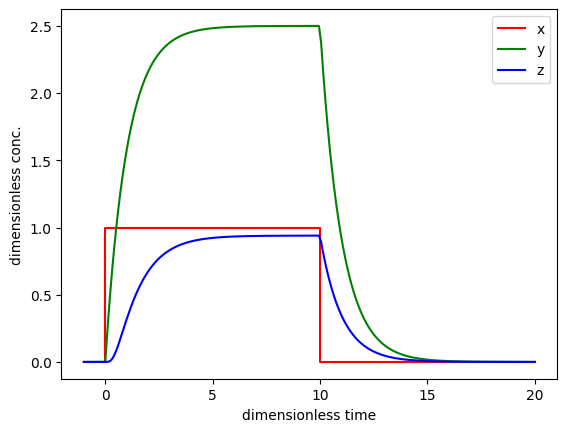

In [19]:
# Parameter values
beta = 5
gamma = 1
kappa = 1
n_xy, n_yz = 3, 3
n_xz = 5

# Plot
plot_ffl(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl="c1", logic="and")

Notice that there is a time delay for production of $Z$ upon stimulation with $X$. This is a result of the `AND` logic. Though $X$ has immediately come up, we have to wait for the signal to pass through $Y$ for $Z$ to come up. This off-response is perhaps more apparent if we normalize the signals.

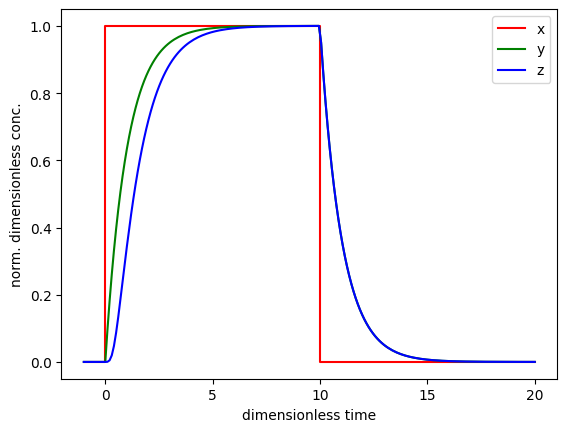

In [20]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        normalized=True,
)

Here, the delay is more apparent, as is the fact that both Y and Z have their levels immediately decrease when the X stimulus is removed. So, we have arrived at a design principle: **The C1-FFL with AND logic has an on-delay, but no off-delay.**

### The magnitude of the delay can be tuned

How might we get a longer delay? If we decrease $\kappa = k_{xz}/k_{yz}$, we are increasing the disparity between the threshold levels needed to turn on gene expression. This should result in a longer time delay. Let's try it!

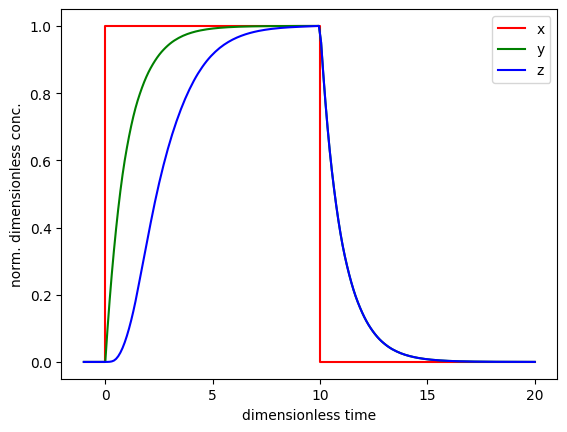

In [22]:
# Update parameter
kappa = 0.001

plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        normalized=True
)

### Making a sweep

Indeed, the delay is longer with small *$\kappa$*. We can quantify how the delay changes with $\kappa$ by plotting how long it takes for the $z$ level to rise to ten percent of its steady state value for various values of $\kappa$.

(0.0, 5.0)

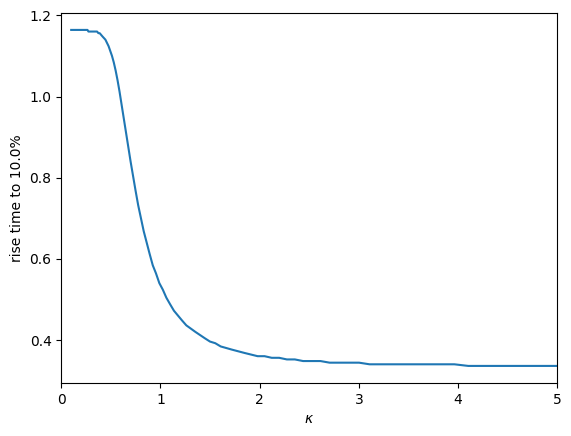

In [12]:
THRESHOLD_FRACTION = 0.1  # 10% of steady state

tau = []
kappa_vals = np.logspace(-1, 2, 200)

# Finer time points
t_ = np.linspace(0, 20, 5000)

for kappa in kappa_vals:
    yz = solve_ffl(
        beta, gamma, kappa, n_xy, n_xz, n_yz, "c1", "and", t_, np.inf, 1
    )
    z_thresh = yz[-1, 1] * THRESHOLD_FRACTION
    i = np.nonzero(yz[:, 1] > z_thresh)[0][0]
    tau.append(t_[i])
    
plt.figure()
plt.plot(kappa_vals, tau)
plt.xlabel('$\kappa$')
plt.ylabel(f'rise time to {THRESHOLD_FRACTION*100}%')
plt.xlim([0,5])

The delay does not change substantially, only about a factor of three over many orders of magnitude.

### The C1-FFL with AND logic and filter out short pulses

Now, let's see what happens if we have a shorter pulse. Due to its similarly with the cascade we previously studied, the delay feature of the C1-FFl should also filter our short pulses.

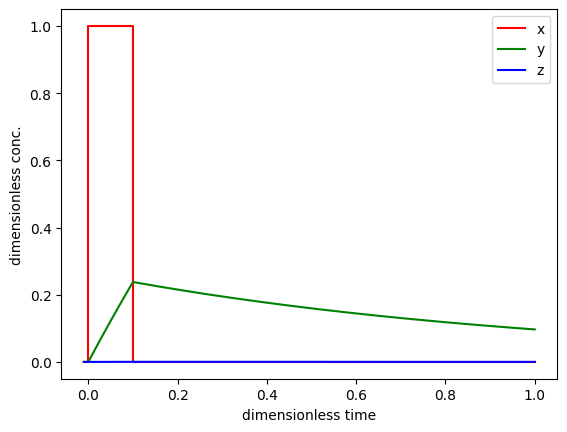

In [13]:
# Shorter pulse
t = np.linspace(0, 1, 200)
t_step_down = 0.1

# Reset kappa and ultrasensitivity
kappa = 1
n_xy, n_xz, n_yz = 3, 5, 3

plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        t=t,
        t_step_down=t_step_down,
        normalized=False,
)

The shorter pulse is ignored in the Z-response because of the delay.

### The sign-sensitivity of the delay is reversed with OR logic

We will now investigate the response of the circuit to the same stimulus, except with `OR` logic.

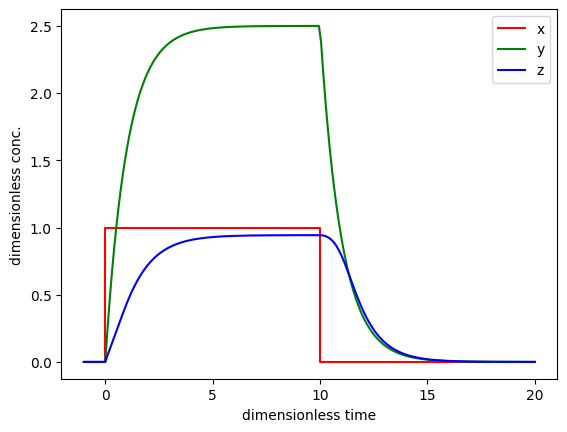

In [14]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="or",
        normalized=False,
)

Again, let's normalize to see it more clearly:

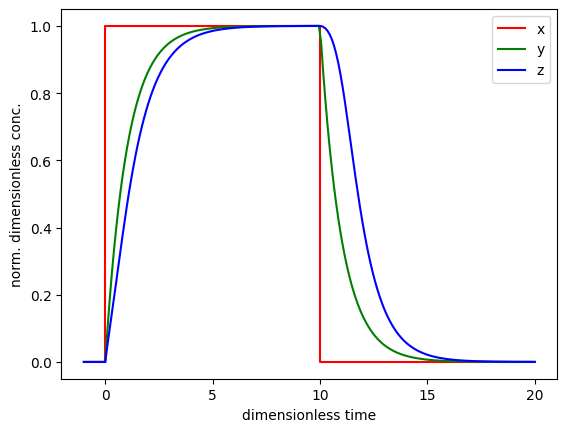

In [15]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="or",
        normalized=True,
)

### Sign sensitive delay is observed experimentally

The arabinose and lac systems in *E. coli* are both turned on by cyclic AMP (cAMP), which stimulates production of CRP, but they have different architectures, shown below.

<div style="width: 300px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/araBAD_lacZYA_systems.png" alt="araBAD and lacZYA">
</figure>

</div>

In both system where multiple species regulate one, AND logic is employed.

Mangan an coworkers ([*J. Molec. Biol.*, 2003](https://doi.org/10.1016/j.jmb.2003.09.049)) performed an experiment where they put a fluorescent reporter under control of the products of these two systems, araBAD and lacZYA, respectively. In the lac system, IPTG was also present, so LacI was inhibited. Thus, lacZYA production was directly activated by CRP. Conversely, the arabinose system is a C1-FFL. 

They measured the fluorescent intensity in cells that were suddenly exposed to cAMP. The response of these two systems to the sudden jump in cAMP is shown in the left plot below.

<div style="width: 550px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/alon_lacZYA_araBAD_cffl.png" alt="response to steps">
</figure>

</div>

While the lac system response immediately, the arabinose system exhibits a lag before responding. This is indicative of a time delay for a step *on* in the stimulus for a C1-FFL. Conversely, after these systems come to steady state and are subjected to a sudden decrease in cAMP, both the arabinose and lac systems respond immediately, without delay, which is also expected from a C1-FFL with `AND` logic.

Kalir and coworkers ([*Mol. Sys. Biol.*, 2005](https://doi.org/10.1038/msb4100010)) did a similar experiment with another C1-FFL circuit found in *E. coli*, this time with `OR` logic. A circuit that regulates flagella formation is a "decorated" C1-FFL, shown below. We say it is decorated because the "Y" gene, in this case FliA, is also autoregulated. Importantly, the regulation of FliL by FliA and FlhDC is governed by `OR` logic.

<div style="width: 300px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/fliA_system.png" alt="fliA system">
</figure>

</div>

Kalir and coworkers used engineered cells in which the FlhDC gene was under control of a promoter which could be induced with L-arabinose, a chemical inducer. The gene product FliL was altered to be fused to GFP to enable fluorescent monitoring of expression levels. To consider a circuit where FlhDC directly activates FliL, Kalir and coworkers used mutant *E. coli* cells in which the *fliA* gene was deleted.

Because of the `OR` logic, we would expect that a sudden increase in FlhDC would result in both the wild type and mutant cells to respond at the same time, that is with no delay. Fluorescence traces from these experiments are shown in the left plot, below.

<div style="width: 550px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/alon_fliA_cffl.png" alt="response to steps fliA">
</figure>

</div>

Both strains show a delay, which is due to waiting for FlhDC to be activated, but both come on at the same time. Conversely, after the inducer is removed and FlhDC levels go down, the system with the wild type C1-FFL circuit shows a delay before the FliL levels drop off, while the mutant does not. This demonstrates the sign-sensitivity with `OR` logic.

## The I1-FFL with AND logic is a pulse generator

We now turn our attention to the other over-represented circuit, the I1-FFL. As a reminder, here is the structure of the circuit.

<div style="width: 150px; margin: auto; margin-top: 20px">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/i1-ffl.png" alt="FFL abundance">
</figure>

</div>

X activates Y and Z, but Y represses Z. We can use the expressions for production rate under `AND` and `OR` logic for one activator/one repressor that we showed above in writing down our dynamical equations. Here, we will consider `AND` logic. The dimensionless dynamical equations are

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta\,\frac{(\kappa x)^{n_{xy}}}{1+(\kappa x)^{n_{xy}}} - y,\\[1em]
\gamma^{-1}\,\frac{\mathrm{d}z}{\mathrm{d}t} &= \frac{x^{n_{xz}}}{(1 + x^{n_{xz}} + y^{n_{yz}})} - z.
\end{align}

For this circuit, we will investigate the response in Z to a sudden, sustained step in stimulus X. We will choose $\gamma = 10$, which means that the dynamics of Z are faster than Y.

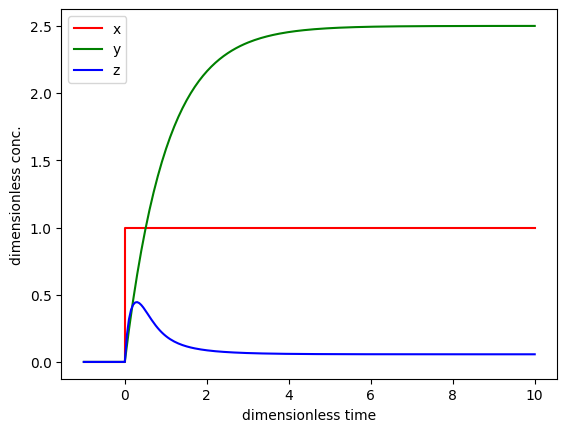

In [23]:
# Parameter values
beta = 5
gamma = 10
kappa = 1
n_xy, n_yz = 3, 3
n_xz = 5
t = np.linspace(0, 10, 200)

# Set up and solve
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="i1",
        logic="and",
        t=t,
        t_step_down=np.inf,
        normalized=False,
)

We see that Z pulses up and then falls down to its steady state value. This is because the presence  X leads to production of Z due to its activation. X also leads to the increase in Y, and once enough Y is present, it can start to repress Z. This brings the Z level back down toward a new steady state where the production rate of Z is a balance between activation by X and repression by Y. Thus, **the I1-FFL with `AND` logic is a pulse generator.**